In [69]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import keras.backend as K

from keras.models import Model, Sequential
from keras.layers import Activation, Dense, Dot, Input
from keras.utils.vis_utils import model_to_dot

from scipy.stats import logistic, multivariate_normal, norm
from scipy.special import expit
from mpl_toolkits.mplot3d import Axes3D

from IPython.display import SVG

In [71]:
plt.style.use('seaborn-notebook')
sns.set_context('notebook')

In [74]:
np.set_printoptions(precision=2,
                    edgeitems=3,
                    linewidth=80,
                    suppress=True)

In [75]:
K.tf.__version__

'1.2.1'

In [76]:
LATENT_DIM = 2
NOISE_DIM = 3
BATCH_SIZE = 128
D_BATCH_SIZE = 128
G_BATCH_SIZE = 128
PRIOR_VARIANCE = 2.

In [77]:
w_min, w_max = -5, 5

In [78]:
w1, w2 = np.mgrid[w_min:w_max:300j, w_min:w_max:300j]

In [79]:
w_grid = np.dstack((w1, w2))
w_grid.shape

(300, 300, 2)

In [80]:
prior = multivariate_normal(mean=np.zeros(LATENT_DIM), 
                            cov=PRIOR_VARIANCE)

In [81]:
log_prior = prior.logpdf(w_grid)
log_prior.shape

(300, 300)

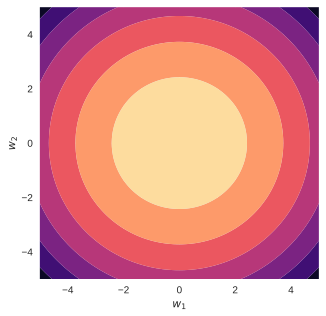

In [82]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.contourf(w1, w2, log_prior, cmap='magma')

ax.set_xlabel('$w_1$')
ax.set_ylabel('$w_2$')

ax.set_xlim(w_min, w_max)
ax.set_ylim(w_min, w_max)

plt.show()

In [83]:
x1 = np.array([ 1.5,  1.])
x2 = np.array([-1.5,  1.])
x3 = np.array([- .5, -1.])

In [84]:
X = np.vstack((x1, x2, x3))
X.shape

(3, 2)

In [85]:
y1 = 1
y2 = 1
y3 = 0

In [86]:
y = np.stack((y1, y2, y3))
y.shape

(3,)

In [87]:
def log_likelihood(w, x, y):
    # equiv. to negative binary cross entropy
    return np.log(expit(np.dot(w.T, x)*(-1)**(1-y)))

In [88]:
llhs = log_likelihood(w_grid.T, X.T, y)
llhs.shape

(300, 300, 3)

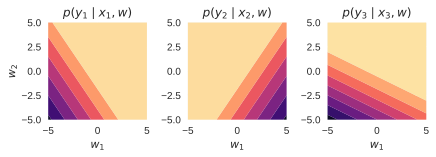

In [89]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(6, 2))
fig.tight_layout()

for i, ax in enumerate(axes):
    
    ax.contourf(w1, w2, llhs[::,::,i], cmap=plt.cm.magma)

    ax.set_xlim(w_min, w_max)
    ax.set_ylim(w_min, w_max)
    
    ax.set_title('$p(y_{{{0}}} \mid x_{{{0}}}, w)$'.format(i+1))
    ax.set_xlabel('$w_1$')    
    
    if not i:
        ax.set_ylabel('$w_2$')

plt.show()

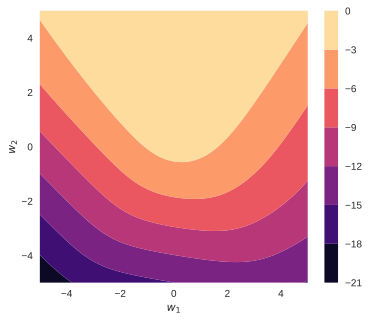

In [90]:
fig, ax = plt.subplots(figsize=(6, 5))

c = ax.contourf(w1, w2, np.sum(llhs, axis=2), 
                cmap=plt.cm.magma)

ax.set_xlabel('$w_1$')
ax.set_ylabel('$w_2$')

ax.set_xlim(w_min, w_max)
ax.set_ylim(w_min, w_max)

plt.colorbar(c)
plt.show()

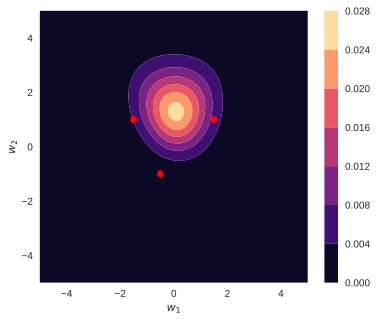

In [91]:
fig, ax = plt.subplots(figsize=(6, 5))

c = ax.contourf(w1, w2, 
                np.exp(log_prior+np.sum(llhs, axis=2)), 
                cmap=plt.cm.magma)
ax.plot(*np.vstack((x1,x2,x3)).T, 'ro')

ax.set_xlabel('$w_1$')
ax.set_ylabel('$w_2$')

ax.set_xlim(w_min, w_max)
ax.set_ylim(w_min, w_max)

plt.colorbar(c)
plt.show()

## Model Definitions

### Density Ratio Estimator (Discriminator) Model

$T_{\psi}(x, z)$

Here we consider

$T_{\psi}(w)$

$T_{\psi} : \mathbb{R}^2 \to \mathbb{R}$

In [92]:
discriminator = Sequential(name='discriminator')
discriminator.add(Dense(10, input_dim=LATENT_DIM, activation='relu'))
discriminator.add(Dense(20, activation='relu'))
discriminator.add(Dense(1, activation=None, name='logit'))
discriminator.add(Activation('sigmoid'))
discriminator.compile(optimizer='adam',
                      loss='binary_crossentropy')

In [93]:
ratio_estimator = Model(
    inputs=discriminator.inputs, 
    outputs=discriminator.get_layer(name='logit').output)

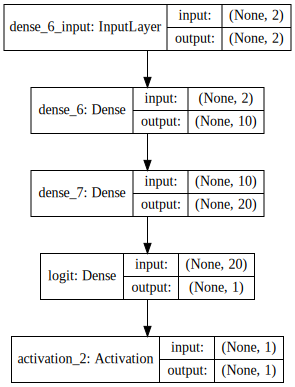

In [94]:
SVG(model_to_dot(discriminator, show_shapes=True)
    .create(prog='dot', format='svg'))

In [95]:
w_grid_ratio = ratio_estimator.predict(w_grid.reshape(300*300, 2))
w_grid_ratio = w_grid_ratio.reshape(300, 300)

Initial density ratio, prior to any training

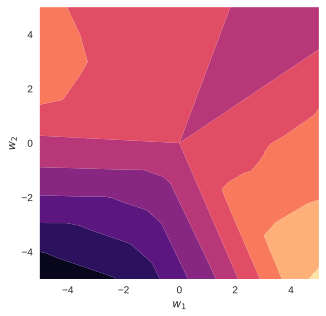

In [96]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.contourf(w1, w2, w_grid_ratio, cmap=plt.cm.magma)

ax.set_xlabel('$w_1$')
ax.set_ylabel('$w_2$')

ax.set_xlim(w_min, w_max)
ax.set_ylim(w_min, w_max)

plt.show()

In [97]:
discriminator.evaluate(prior.rvs(size=5), np.ones(5))

5/5 [==============================] - 0s


0.60724371671676636

### Approximate Inference Model

$z_{\phi}(x, \epsilon)$

Here we only consider

$z_{\phi}(\epsilon)$

$z_{\phi}: \mathbb{R}^3 \to \mathbb{R}^2$

In [98]:
inference = Sequential()
inference.add(Dense(10, input_dim=NOISE_DIM, activation='relu'))
inference.add(Dense(20, activation='relu'))
inference.add(Dense(LATENT_DIM, activation=None))
inference.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 10)                40        
_________________________________________________________________
dense_9 (Dense)              (None, 20)                220       
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 42        
Total params: 302
Trainable params: 302
Non-trainable params: 0
_________________________________________________________________


The variational parameters $\phi$ are the trainable weights of the approximate inference model

In [99]:
phi = inference.trainable_weights
phi

[<tf.Variable 'dense_8/kernel:0' shape=(3, 10) dtype=float32_ref>,
 <tf.Variable 'dense_8/bias:0' shape=(10,) dtype=float32_ref>,
 <tf.Variable 'dense_9/kernel:0' shape=(10, 20) dtype=float32_ref>,
 <tf.Variable 'dense_9/bias:0' shape=(20,) dtype=float32_ref>,
 <tf.Variable 'dense_10/kernel:0' shape=(20, 2) dtype=float32_ref>,
 <tf.Variable 'dense_10/bias:0' shape=(2,) dtype=float32_ref>]

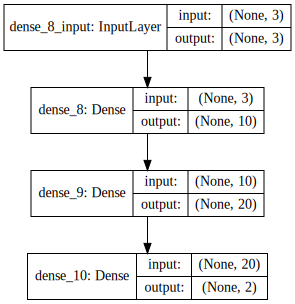

In [100]:
SVG(model_to_dot(inference, show_shapes=True)
    .create(prog='dot', format='svg'))

In [101]:
eps = np.random.randn(BATCH_SIZE, NOISE_DIM)

In [102]:
w_posterior_samples = inference.predict(eps)
w_posterior_samples.shape

(128, 2)

In [103]:
w_prior_samples = prior.rvs(size=BATCH_SIZE)
w_prior_samples.shape

(128, 2)

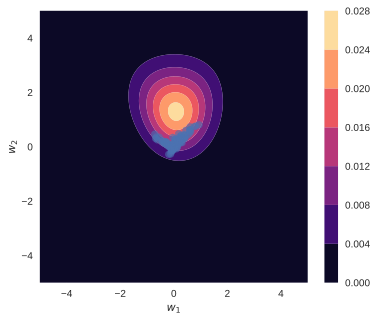

In [104]:
fig, ax = plt.subplots(figsize=(6, 5))

c = ax.contourf(w1, w2, 
                np.exp(log_prior+np.sum(llhs, axis=2)), 
                cmap=plt.cm.magma)

ax.scatter(*w_posterior_samples.T, alpha=.6)

ax.set_xlabel('$w_1$')
ax.set_ylabel('$w_2$')

ax.set_xlim(w_min, w_max)
ax.set_ylim(w_min, w_max)

plt.colorbar(c)
plt.show()

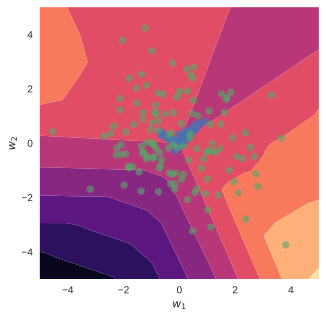

In [105]:
fig, ax = plt.subplots(figsize=(5, 5))

w_grid_ratio = ratio_estimator.predict(w_grid.reshape(300*300, 2))
w_grid_ratio = w_grid_ratio.reshape(300, 300)

ax.contourf(w1, w2, w_grid_ratio, cmap=plt.cm.magma)
ax.scatter(*w_posterior_samples.T, alpha=.6)
ax.scatter(*w_prior_samples.T, alpha=.6)

ax.set_xlabel('$w_1$')
ax.set_ylabel('$w_2$')

ax.set_xlim(w_min, w_max)
ax.set_ylim(w_min, w_max)

plt.show()

In [106]:
sess = K.get_session()

In [107]:
w_prior_samples = K.random_normal(shape=(BATCH_SIZE, LATENT_DIM), 
                                  stddev=np.sqrt(PRIOR_VARIANCE))

In [108]:
eps = K.random_normal(shape=(BATCH_SIZE, NOISE_DIM))

In [109]:
w_posterior_samples = inference(eps)
w_posterior_samples

<tf.Tensor 'sequential_2/dense_10/BiasAdd:0' shape=(128, 2) dtype=float32>

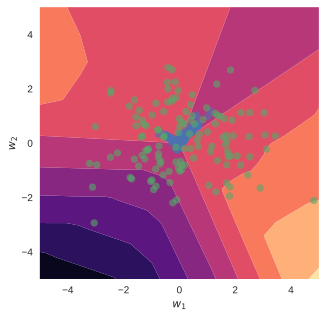

In [110]:
fig, ax = plt.subplots(figsize=(5, 5))

w_grid_ratio = ratio_estimator.predict(w_grid.reshape(300*300, 2))
w_grid_ratio = w_grid_ratio.reshape(300, 300)

ax.contourf(w1, w2, w_grid_ratio, cmap=plt.cm.magma)
ax.scatter(*sess.run(w_posterior_samples).T, alpha=.6)
ax.scatter(*sess.run(w_prior_samples).T, alpha=.6)

ax.set_xlabel('$w_1$')
ax.set_ylabel('$w_2$')

ax.set_xlim(w_min, w_max)
ax.set_ylim(w_min, w_max)

plt.show()

In [111]:
discrim_loss = K.mean(
    K.binary_crossentropy(
        discriminator(w_posterior_samples), 
        K.ones_like(discriminator(w_posterior_samples))) +
    K.binary_crossentropy(
        discriminator(w_prior_samples), 
        K.zeros_like(discriminator(w_prior_samples))))

In [112]:
discrim_loss.eval(session=sess)

1.385956

In [113]:
opt = K.tf.train.AdamOptimizer(3e-3, beta1=0.9)

In [114]:
discrim_train_op = opt.minimize(discrim_loss, 
                                var_list=discriminator.trainable_weights)

In [115]:
K.mean(ratio_estimator(w_posterior_samples))

<tf.Tensor 'Mean_14:0' shape=() dtype=float32>

In [116]:
K.expand_dims(K.constant(y), 1)

<tf.Tensor 'ExpandDims_8:0' shape=(3, 1) dtype=float32>

In [117]:
K.pow(K.constant(-1), 1-K.expand_dims(K.constant(y), 1))

<tf.Tensor 'Pow_7:0' shape=(3, 1) dtype=float32>

In [118]:
K.dot(K.constant(X), K.transpose(w_posterior_samples))

<tf.Tensor 'MatMul_7:0' shape=(3, 128) dtype=float32>

In [119]:
K.dot(K.constant(X), K.transpose(w_posterior_samples))*K.pow(K.constant(-1), 1-K.expand_dims(K.constant(y), 1))

<tf.Tensor 'mul_10:0' shape=(3, 128) dtype=float32>

In [120]:
K.sigmoid(K.dot(K.constant(X), K.transpose(w_posterior_samples)) *
          K.pow(K.constant(-1), 1-K.expand_dims(K.constant(y), 1)))

<tf.Tensor 'Sigmoid_5:0' shape=(3, 128) dtype=float32>

In [121]:
K.log(K.sigmoid(K.dot(K.constant(X), K.transpose(w_posterior_samples)) *
                K.pow(K.constant(-1), 1-K.expand_dims(K.constant(y), 1))))

<tf.Tensor 'Log_10:0' shape=(3, 128) dtype=float32>

In [122]:
K.mean(K.log(K.sigmoid(K.dot(K.constant(X), K.transpose(w_posterior_samples)) *
                       K.pow(K.constant(-1), 1-K.expand_dims(K.constant(y), 1)))))

<tf.Tensor 'Mean_15:0' shape=() dtype=float32>

In [123]:
log_likelihood = K.mean(K.log(K.sigmoid(K.dot(K.constant(X), K.transpose(w_posterior_samples)) *
                                        K.pow(K.constant(-1), 1-K.expand_dims(K.constant(y), 1)))))
log_likelihood

<tf.Tensor 'Mean_16:0' shape=() dtype=float32>

In [124]:
inference_loss = K.mean(ratio_estimator(w_posterior_samples)) - log_likelihood

In [125]:
inference_loss.eval(session=sess)

0.62940556

In [126]:
inference_train_op = opt.minimize(inference_loss, 
                                  var_list=inference.trainable_weights)

In [127]:
keras_llh = K.reshape(K.sum(K.log(K.sigmoid(K.dot(K.constant(X), K.reshape(K.permute_dimensions(K.constant(w_grid), (2, 0, 1)), shape=(2, 300*300))) *
                                            K.pow(K.constant(-1), 1-K.expand_dims(K.constant(y), 1)))), 
                            axis=0), 
                      shape=(300, 300))
keras_llh

<tf.Tensor 'Reshape_3:0' shape=(300, 300) dtype=float32>

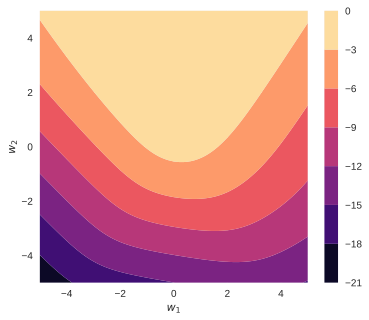

In [128]:
fig, ax = plt.subplots(figsize=(6, 5))

c = ax.contourf(w1, w2, sess.run(keras_llh), cmap=plt.cm.magma)

ax.set_xlabel('$w_1$')
ax.set_ylabel('$w_2$')

ax.set_xlim(w_min, w_max)
ax.set_ylim(w_min, w_max)

plt.colorbar(c)
plt.show()

In [129]:
np.allclose(sess.run(keras_llh), 
            np.sum(llhs, axis=2))

True

In [130]:
sess = K.get_session()

In [131]:
for d_step in range(3*300):
    loss, _ = sess.run([discrim_loss, discrim_train_op])
    print(loss)

1.38532
1.3579
1.37045
1.32634
1.33504
1.27227
1.28475
1.24287
1.22682
1.22881
1.21535
1.19214
1.15849
1.14416
1.14371
1.14085
1.09653
1.1075
1.10195
1.09052
1.05989
1.08887
1.04995
1.05183
1.05929
1.03833
1.01648
1.03497
1.01955
0.960189
0.988754
0.951096
1.00077
0.951274
0.980649
0.966437
0.972831
0.949386
0.957259
0.926495
0.937377
0.916226
0.937085
0.914591
0.889111
0.904115
0.874599
0.862437
0.820481
0.895674
0.840388
0.906279
0.875646
0.839755
0.848321
0.792723
0.82651
0.818164
0.811942
0.773857
0.748018
0.803157
0.784107
0.763402
0.749615
0.775418
0.760771
0.789065
0.773577
0.716524
0.741916
0.747315
0.7378
0.732429
0.715211
0.701757
0.66048
0.696592
0.67441
0.715436
0.752388
0.672804
0.655467
0.693615
0.662632
0.660639
0.670306
0.625209
0.672787
0.661013
0.612875
0.636962
0.598916
0.662136
0.55278
0.613553
0.58413
0.567281
0.625276
0.573121
0.602104
0.579841
0.568854
0.565051
0.569442
0.54241
0.546366
0.538198
0.552248
0.601788
0.509559
0.536433
0.548869
0.538587
0.507484
0.508

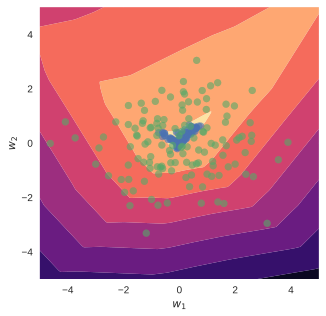

In [132]:
fig, ax = plt.subplots(figsize=(5, 5))

w_grid_ratio = ratio_estimator.predict(w_grid.reshape(300*300, 2))
w_grid_ratio = w_grid_ratio.reshape(300, 300)

ax.contourf(w1, w2, w_grid_ratio, cmap=plt.cm.magma)
ax.scatter(*sess.run(w_posterior_samples).T, alpha=.6)
ax.scatter(*sess.run(w_prior_samples).T, alpha=.6)

ax.set_xlabel('$w_1$')
ax.set_ylabel('$w_2$')

ax.set_xlim(w_min, w_max)
ax.set_ylim(w_min, w_max)

plt.show()

In [133]:
for step in range(3*200):

    g_loss, _ = sess.run([inference_loss, inference_train_op])

    for d_step in range(3*50):

        d_loss, _ = sess.run([discrim_loss, discrim_train_op])
    
    print(d_loss, g_loss)

0.299976 3.34463
0.42477 3.42557
0.489073 3.16171
0.492646 2.78832
0.697428 2.15677
0.733206 1.72106
0.733298 1.52407
0.807746 1.29283
1.01707 1.36824
0.982902 1.16122
0.972628 1.10115
1.03581 1.21175
1.08277 1.57636
1.06537 1.18987
1.08656 1.15926
1.12824 1.12963
1.11872 1.36252
1.20765 1.06292
1.25455 1.00747
1.29707 1.10839
1.29748 1.12028
1.30085 0.914041
1.32332 0.986965
1.29178 0.985552
1.32019 1.00764
1.2936 1.06811
1.31705 1.0777
1.34883 1.0747
1.25078 0.984631
1.27866 1.05978
1.26078 1.02381
1.23433 0.950675
1.17123 0.905802
1.20704 1.02897
1.17519 0.958528
1.18514 0.944483
1.16954 0.834288
1.2178 0.968593
1.16209 0.839961
1.20248 0.932302
1.14983 0.903876
1.22635 0.947336
1.14538 1.02064
1.18963 0.978661
1.19453 0.916686
1.30689 0.953143
1.23519 0.983169
1.28594 0.952351
1.26316 0.985327
1.25242 0.95212
1.25774 0.928886
1.26975 0.893379
1.27822 0.898999
1.28621 0.888295
1.33779 0.949368
1.22241 0.955898
1.33705 0.829938
1.27576 0.985328
1.32099 0.844981
1.31612 0.929675
1.271

1.28739 0.89501
1.37896 0.883422
1.34163 0.900157
1.28176 0.91432
1.28685 0.929243
1.24621 0.903233
1.335 0.856527
1.28115 0.875209
1.27907 0.860913
1.3647 0.907754
1.27064 0.892142
1.30152 0.840292
1.25153 0.852177
1.29679 0.869337
1.27773 0.906446
1.27954 0.891281
1.23566 0.907888
1.33123 0.878992
1.29079 0.891348
1.39201 0.900257
1.29935 0.898852
1.29303 0.917898
1.24376 0.871551
1.36831 0.886407
1.25888 0.899488
1.2399 0.867973
1.30075 0.906447
1.26663 0.894795
1.28937 0.896779
1.28319 0.915181
1.2914 0.903844
1.22604 0.892134
1.28493 0.865643
1.25693 0.915223
1.17788 0.91207
1.31807 0.887731
1.31806 0.877444
1.33148 0.913566
1.31501 0.895104
1.21561 0.900399
1.32397 0.882778
1.2412 0.887779
1.28798 0.901722
1.32204 0.891469
1.30445 0.878949
1.3195 0.893537
1.29647 0.893651
1.30864 0.90272
1.33842 0.906772
1.27186 0.884606
1.25376 0.912435
1.24348 0.88483
1.32806 0.885722
1.26289 0.875498
1.34817 0.930449
1.2741 0.836675
1.31649 0.894658
1.28392 0.890792
1.3196 0.912111
1.32396 0.8

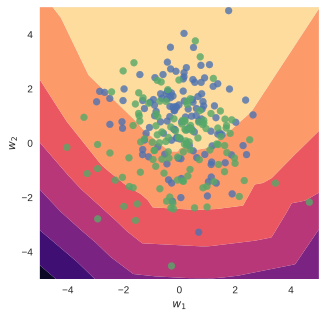

In [134]:
fig, ax = plt.subplots(figsize=(5, 5))

w_grid_ratio = ratio_estimator.predict(w_grid.reshape(300*300, 2))
w_grid_ratio = w_grid_ratio.reshape(300, 300)

ax.contourf(w1, w2, w_grid_ratio, cmap=plt.cm.magma)
ax.scatter(*sess.run(w_posterior_samples).T, alpha=.8)
ax.scatter(*sess.run(w_prior_samples).T, alpha=.8)

ax.set_xlabel('$w_1$')
ax.set_ylabel('$w_2$')

ax.set_xlim(w_min, w_max)
ax.set_ylim(w_min, w_max)

plt.show()

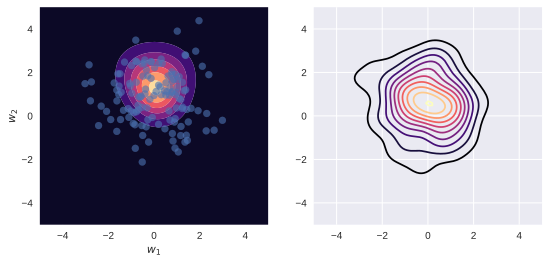

In [138]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(9, 4))

sns.kdeplot(*sess.run(w_posterior_samples).T, cmap='magma', ax=ax2)

ax2.set_xlim(w_min, w_max)
ax2.set_ylim(w_min, w_max)

ax1.contourf(w1, w2, 
             np.exp(log_prior+np.sum(llhs, axis=2)), 
             cmap=plt.cm.magma)

ax1.scatter(*sess.run(w_posterior_samples).T, alpha=.6)

ax1.set_xlabel('$w_1$')
ax1.set_ylabel('$w_2$')

ax1.set_xlim(w_min, w_max)
ax1.set_ylim(w_min, w_max)

plt.show()